In [1]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import seaborn as sns

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [2]:
sns.set(style="whitegrid")

def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    a = 1
    b = 100
    x0, x1 = x[0], x[1]

    val = (a - x0)**2 + b * (x1 - x0**2)**2

    dv_dx0 = -2 * (a - x0) - 4 * b * x0 * (x1 - x0**2)
    dv_dx1 = 2 * b * (x1 - x0**2)

    grad = np.array([dv_dx0, dv_dx1])
    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)
    a = 1
    b = 100
    x0, x1 = x[0], x[1]

    # Hessian matrix components
    d2v_dx0x0 = 2 - 4 * b * x1 + 12 * b * x0**2
    d2v_dx0x1 = -4 * b * x0
    d2v_dx1x0 = -4 * b * x0
    d2v_dx1x1 = 2 * b

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                        [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian

def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f."""
    history = []
    theta = np.array(theta0, dtype=float)
    step = 0

    while step < max_steps:
        val, grad = f(theta)

        history.append((theta.copy(), (val, grad)))

        theta = theta - alpha * grad

        if np.linalg.norm(grad) < stop_tolerance:
            break

        step += 1

    return theta, history


Gradient Descent Results:
  - Found optimum at: [1. 1.]
  - Number of steps taken: 54320
  - True minimum is at: [1, 1]


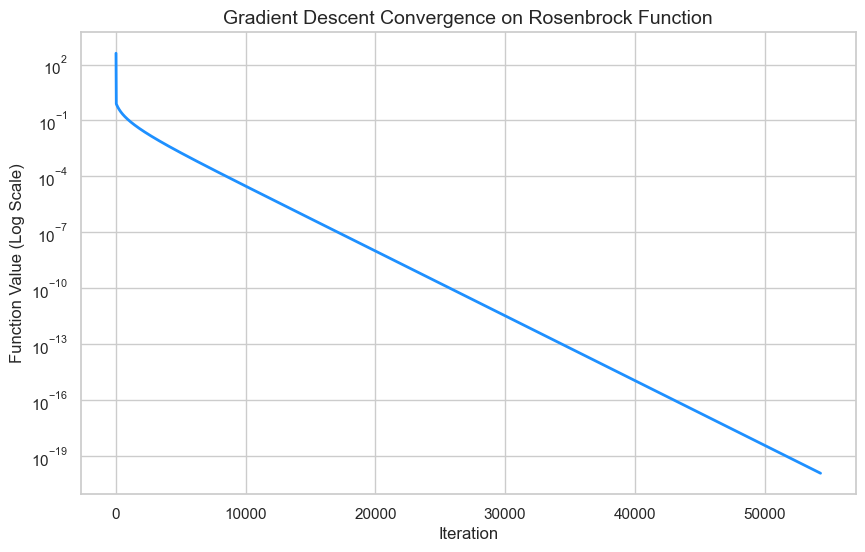

In [3]:
# Find the optimum of rosenbrock function

X0 = [0., 2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=int(1e6))

print(f"\nGradient Descent Results:")
print(f"  - Found optimum at: {Xopt}")
print(f"  - Number of steps taken: {len(Xhist)}")
print(f"  - True minimum is at: [1, 1]")

gd_values = [step[1][0] for step in Xhist]

# Plot how the value changes over iterations
plt.figure(figsize=(10, 6))
plt.plot(gd_values, color="dodgerblue", linewidth=2)
plt.yscale("log")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Function Value (Log Scale)", fontsize=12)
plt.title("Gradient Descent Convergence on Rosenbrock Function", fontsize=14)
plt.show()


Newton's Method Results:
  - Found optimum at: [1. 1.]
  - Number of steps taken: 7
  - True minimum is at: [1, 1]


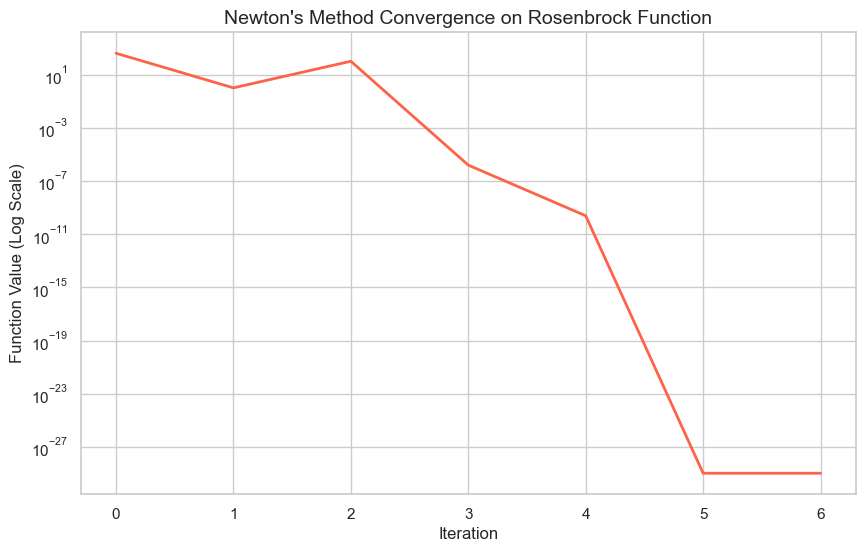

In [4]:
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search."""
    theta = np.array(theta0, dtype=float)
    history = []
    step = 0

    while step < max_steps:
        val, grad, hessian = f(theta)

        history.append((theta.copy(), val, grad))

        if np.linalg.norm(grad) < stop_tolerance:
            break

        try:
            hessian_inv = np.linalg.inv(hessian)
            delta = -hessian_inv @ grad
        except np.linalg.LinAlgError:
            print("Hessian is singular, cannot proceed with Newton's method.")
            break

        theta = theta + alpha * delta

        step += 1

    history.append((theta, val, grad))
    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print(f"\nNewton's Method Results:")
print(f"  - Found optimum at: {Xopt}")
print(f"  - Number of steps taken: {len(Xhist)}")
print(f"  - True minimum is at: [1, 1]")

newton_values = [step[1] for step in Xhist]

plt.figure(figsize=(10, 6))
plt.plot(newton_values, color="tomato", linewidth=2)
plt.yscale("log")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Function Value (Log Scale)", fontsize=12)
plt.title("Newton's Method Convergence on Rosenbrock Function", fontsize=14)
plt.show()

# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [5]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4775981.99it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 216264.69it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1819552.92it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 105278.88it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [8]:
import torch.nn as nn

num_epoch = 20
criterion = nn.MSELoss()

sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [1/20], Loss: 0.0895
Epoch [2/20], Loss: 0.0878
Epoch [3/20], Loss: 0.0848
Epoch [4/20], Loss: 0.0799
Epoch [5/20], Loss: 0.0736
Epoch [6/20], Loss: 0.0676
Epoch [7/20], Loss: 0.0630
Epoch [8/20], Loss: 0.0595
Epoch [9/20], Loss: 0.0569
Epoch [10/20], Loss: 0.0548
Epoch [11/20], Loss: 0.0531
Epoch [12/20], Loss: 0.0517
Epoch [13/20], Loss: 0.0505
Epoch [14/20], Loss: 0.0495
Epoch [15/20], Loss: 0.0486
Epoch [16/20], Loss: 0.0478
Epoch [17/20], Loss: 0.0471
Epoch [18/20], Loss: 0.0465
Epoch [19/20], Loss: 0.0459
Epoch [20/20], Loss: 0.0453


In [9]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

Test Accuracy: 82.80%


In [10]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)

Epoch [1/20], Loss: 0.0840
Epoch [2/20], Loss: 0.0632
Epoch [3/20], Loss: 0.0517
Epoch [4/20], Loss: 0.0454
Epoch [5/20], Loss: 0.0408
Epoch [6/20], Loss: 0.0370
Epoch [7/20], Loss: 0.0339
Epoch [8/20], Loss: 0.0313
Epoch [9/20], Loss: 0.0291
Epoch [10/20], Loss: 0.0273
Epoch [11/20], Loss: 0.0259
Epoch [12/20], Loss: 0.0247
Epoch [13/20], Loss: 0.0237
Epoch [14/20], Loss: 0.0229
Epoch [15/20], Loss: 0.0222
Epoch [16/20], Loss: 0.0216
Epoch [17/20], Loss: 0.0210
Epoch [18/20], Loss: 0.0205
Epoch [19/20], Loss: 0.0201
Epoch [20/20], Loss: 0.0197


In [11]:
# Test the model
test(reluMLP, test_dataloader, device)

Test Accuracy: 92.38%


### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [21]:
def xavier_initialization(layer):
    if isinstance(layer, FCLayer):
        nn.init.xavier_uniform_(layer.weights)

complex_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    FCLayer(256, 128),
    ReLULayer(),
    FCLayer(128, 64),
    ReLULayer(),
    FCLayer(64, 10)
)

complex_reluMLP.apply(xavier_initialization)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
sgd = SGD(complex_reluMLP.parameters(), learning_rate=learning_rate)

subset_size = 500
batch_size = 16
subset_train_dataloader = DataLoader(
    torch.utils.data.Subset(train_dataset, range(subset_size)),
    batch_size=batch_size,
    shuffle=True
)

num_epochs = 50
complex_reluMLP = train(complex_reluMLP, criterion, sgd, subset_train_dataloader, num_epochs, device=device)

print("\nAccuracy on training subset (overfitted model):")
test(complex_reluMLP, subset_train_dataloader, device=device)

print("\nAccuracy on test set (overfitted model):")
test(complex_reluMLP, test_dataloader, device=device)


Epoch [1/50], Loss: 2.3157
Epoch [2/50], Loss: 2.2954
Epoch [3/50], Loss: 2.2756
Epoch [4/50], Loss: 2.2563
Epoch [5/50], Loss: 2.2375
Epoch [6/50], Loss: 2.2182
Epoch [7/50], Loss: 2.1994
Epoch [8/50], Loss: 2.1808
Epoch [9/50], Loss: 2.1618
Epoch [10/50], Loss: 2.1425
Epoch [11/50], Loss: 2.1231
Epoch [12/50], Loss: 2.1037
Epoch [13/50], Loss: 2.0834
Epoch [14/50], Loss: 2.0632
Epoch [15/50], Loss: 2.0426
Epoch [16/50], Loss: 2.0216
Epoch [17/50], Loss: 2.0002
Epoch [18/50], Loss: 1.9787
Epoch [19/50], Loss: 1.9564
Epoch [20/50], Loss: 1.9340
Epoch [21/50], Loss: 1.9113
Epoch [22/50], Loss: 1.8882
Epoch [23/50], Loss: 1.8651
Epoch [24/50], Loss: 1.8412
Epoch [25/50], Loss: 1.8171
Epoch [26/50], Loss: 1.7932
Epoch [27/50], Loss: 1.7685
Epoch [28/50], Loss: 1.7437
Epoch [29/50], Loss: 1.7191
Epoch [30/50], Loss: 1.6953
Epoch [31/50], Loss: 1.6703
Epoch [32/50], Loss: 1.6459
Epoch [33/50], Loss: 1.6210
Epoch [34/50], Loss: 1.5963
Epoch [35/50], Loss: 1.5718
Epoch [36/50], Loss: 1.5474
E

In [18]:
from layers import DropoutLayer

dropout_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    DropoutLayer(0.5),
    
    FCLayer(256, 128),
    ReLULayer(),
    DropoutLayer(0.5),
    
    FCLayer(128, 64),
    ReLULayer(),
    DropoutLayer(0.5),
    
    FCLayer(64, 10)
)

sgd = SGD(dropout_reluMLP.parameters(), learning_rate=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
dropout_reluMLP = train(dropout_reluMLP, criterion, sgd, train_dataloader, num_epochs, device=device)

print("\nAccuracy on test set (model with dropout):")
test(dropout_reluMLP, test_dataloader, device=device)


Epoch [1/20], Loss: 2.3016
Epoch [2/20], Loss: 2.3013
Epoch [3/20], Loss: 2.3012
Epoch [4/20], Loss: 2.3012
Epoch [5/20], Loss: 2.3011
Epoch [6/20], Loss: 2.3011
Epoch [7/20], Loss: 2.3009
Epoch [8/20], Loss: 2.3006
Epoch [9/20], Loss: 2.2992
Epoch [10/20], Loss: 2.2515
Epoch [11/20], Loss: 1.8093
Epoch [12/20], Loss: 1.2720
Epoch [13/20], Loss: 0.9777
Epoch [14/20], Loss: 0.7759
Epoch [15/20], Loss: 0.6290
Epoch [16/20], Loss: 0.5319
Epoch [17/20], Loss: 0.4649
Epoch [18/20], Loss: 0.4166
Epoch [19/20], Loss: 0.3804
Epoch [20/20], Loss: 0.3493

Accuracy on test set (model with dropout):
Test Accuracy: 94.30%
